In [1]:
# Demonstrates the Adrian, Crump and Moench (2013) term structure estimation procedure.
# This procedure allows instantaneous estimation of an affine term structure model.


import pandas as pd
import numpy as np
from numpy import newaxis
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# User-specified options.
# Compute yields and excess returns for maturities up to 10 years / 120 months.
n_maturities = 120  
# Use five factors (i.e. five principal components of yields)
K = 5  
# Use excess returns at these maturities to estimate the model.
rx_maturities = (6, 18, 24, 36, 48, 60, 84, 120) 


# Helper functions
def vec(x):
    return np.reshape(x, (-1, 1))
def vec_quad_form(x):
    return vec(np.outer(x, x))

In [2]:
# Load data
from load_gsw import * 

rawYields, plot_dates = load_gsw('data/gsw_ns_params.xlsx', n_maturities)
t = rawYields.shape[0] - 1  # Number of observations

# Compute log excess returns from continuously compounded yields
ttm = np.arange(1.0, n_maturities + 1.0)[newaxis, :] / 12.0
logPrices = - rawYields * ttm
rf = -logPrices[:-1, [0]]
rx = logPrices[1:, :-1] - logPrices[:-1, 1:] - rf

In [3]:
# Extract principal components
scaledYields = StandardScaler(with_std=True).fit_transform(rawYields)[:, 0:120]
scaledYieldCov = np.cov(scaledYields.T)
[eigenvalues, eigenvectors] = np.linalg.eig(scaledYieldCov)
yieldPCs = StandardScaler().fit_transform(scaledYields @ np.real(eigenvectors))
X = yieldPCs[:, 0:K].T

In [4]:
# Step (1) of the three-step procedure: estimate VAR(1) for the time series of pricing factors.

X_lhs = X[:, 1:]  #X_t+1. Left hand side of VAR.
X_rhs = np.vstack((np.ones((1, t)), X[:, 0:-1])) #X_t and a constant.
var_coeffs = (X_lhs @ np.linalg.pinv(X_rhs))
mu = var_coeffs[:, [0]]
phi = var_coeffs[:, 1:]

v = X_lhs - var_coeffs @ X_rhs
Sigma = v @ v.T / t

In [5]:
# Step (2) of the three-step procedure: regress log excess returns on the factors.
selected_rx = rx[:, [x - 2 for x in rx_maturities]].T  # Offset by 2 since index 0 is excess return on a 2m bond
N = selected_rx.shape[0]
Z = np.vstack((np.ones((1, t)), v, X[:, 0:-1]))  #Innovations and lagged X
abc = selected_rx @ np.linalg.pinv(Z)
E = selected_rx - abc @ Z
sigmasq_ret = np.sum(E * E) / E.size

a = abc[:, [0]]
beta = abc[:, 1:K+1].T
c = abc[:, K+1:]


In [6]:
# Step (3) of the three-step procedure: Run cross-sectional regressions
BStar = np.squeeze(np.apply_along_axis(vec_quad_form, 1, beta.T))
lambda1 = np.linalg.pinv(beta.T) @ c
lambda0 = np.linalg.pinv(beta.T) @ (a + 1/2 * (BStar @ vec(Sigma) + sigmasq_ret))


In [7]:
# Run bond pricing recursions
A = np.zeros((1, n_maturities))
B = np.zeros((K, n_maturities))

delta = rf.T @ np.linalg.pinv(np.vstack((np.ones((1, t)), X[:, 0:-1])))
delta0 = delta[[0], [0]]
delta1 = delta[[0], 1:]

A[0, 0] = - delta0
B[:, 0] = - delta1

for i in range(0, n_maturities - 1):
    A[0, i+1] = A[0, i] + B[:, i].T @ (mu - lambda0) + 1/2 * (B[:, i].T @ Sigma @ B[:, i] + 0 * sigmasq_ret) - delta0
    B[:, i+1] = B[:, i] @ (phi - lambda1) - delta1


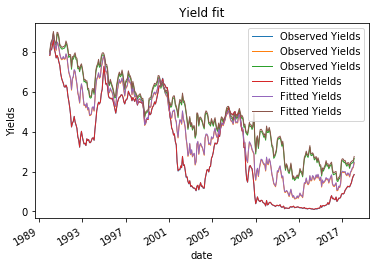

In [11]:
# Construct fitted yields
fittedLogPrices = (A.T + B.T @ X).T
fittedYields = - fittedLogPrices / ttm

# Plot fit for 1y, 5y, 10y bonds
plt.interactive(True)
plt.figure(dpi=144)
fig, axes = plt.subplots()
axes.plot(plot_dates, rawYields[:, (11, 59, 119)], label="Observed Yields", linewidth=1)
axes.plot(plot_dates, fittedYields[:, (11, 59, 119)], label = "Fitted Yields", linewidth=1)
axes.xaxis.set_major_locator(mdates.AutoDateLocator())
axes.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
fig.autofmt_xdate()
axes.set_xlabel("date")
axes.set_ylabel("Yields")
axes.set_title("Yield fit")
axes.legend()
plt.show()